In [1]:
# Import necessary libraries
import numpy as np
from time import sleep
import pandas as pd
from scipy.linalg import eig 
import re
import json
import os
import matplotlib 
%load_ext autotime
%matplotlib inline

In [ ]:
""" The workflow is as follows:
-- Scrape regular season results, playoff results, and regular season standings from basketball reference (1977 - 2017)
-- Form a voting matrix using a specified alpha level using regular season results for each year
-- Get the team ratings for each season (and subsequent rankings) by solving the matrix for its stationary distribution (Markov Method)
-- Use both the Markov Rankings and regular season standings to make predictions for the playoff series for each season
-- Compare the total accuracies of the different ranking methods
"""

In [6]:
# Function to load the data already scraped from the web
def load_all_data():
    regular_season_data = {}
    path = "/Users/JasonKatz/Desktop/NBA_Data/Regular_Season/"
    for file in os.listdir(path):
        regular_season_data[file[0:4]] = pd.read_csv(path + file)
        
    playoff_data = {}
    path = "/Users/JasonKatz/Desktop/NBA_Data/Playoffs/"
    for file in os.listdir(path):
        playoff_data[file[0:4]] = pd.read_csv(path + file)
        
    with open("/Users/JasonKatz/Desktop/NBA_Data/standings.json") as json_data:
        standings_data = json.load(json_data)
        
    return regular_season_data, playoff_data, standings_data

time: 14.9 ms


In [7]:
# Function to get the winning team and losing team names from a row containing the game information
def game_result(game):
    if game['PTS'] > game['PTS.1']:
        winning_team = game['Visitor/Neutral']
        losing_team = game['Home/Neutral']
    else:
        winning_team = game['Home/Neutral']
        losing_team = game['Visitor/Neutral']
    return winning_team, losing_team

time: 5.37 ms


In [8]:
# Function to scrape regular season game information from basketball reference
def get_regular_season_results(year_start, year_end):
    all_data = {}
    months = ['october', 'november', 'december', 'january', 'february', 'march', 'april']
    for year in range(year_start, year_end+1):
        table = pd.read_html('https://www.basketball-reference.com/leagues/NBA_' + str(year) + '_games-april.html')[0]
        teams = list(np.sort(list(set(table['Visitor/Neutral']))))[0:30]
        voting_matrix = pd.DataFrame(0, columns=teams, index=teams)
        data = pd.DataFrame()
        for month in months:
            try:
                table = pd.read_html('https://www.basketball-reference.com/leagues/NBA_' + str(year) + '_games-' + month + '.html')[0]
                if year == 1981:
                    if month == 'march':
                        table = table.iloc[0:table[table['Date'] == 'Playoffs'].index[0],]
                elif month == 'april':
                    table = table.iloc[0:table[table['Date'] == 'Playoffs'].index[0],]
                data = data.append(table)
            except:
                pass
        all_data[year] = data
    return all_data

time: 23.7 ms


In [9]:
# Function to get team rankings from regular season results
def get_markov_rankings(data, alpha=0):
    
    # Create the voting matrix
    teams = list(np.sort(list(set(data['Home/Neutral']))))
    voting_matrix = pd.DataFrame(0, columns=teams, index=teams)
    for idx,row in data.iterrows():
        winning_team, losing_team = game_result(row)
        if alpha == 0:
            voting_matrix.loc[winning_team, losing_team] += alpha
            voting_matrix.loc[losing_team, winning_team] += 1
        else:
            voting_matrix.loc[winning_team, losing_team] += 1
            voting_matrix.loc[losing_team, winning_team] += alpha
    voting_matrix = voting_matrix.div(voting_matrix.sum(axis=1), axis=0)
    voting_matrix = np.matrix(voting_matrix)
    
    # Find the stationary distribution of the voting matrix
    S, U = eig(voting_matrix.T)
    stationary = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
    stationary = stationary / np.sum(stationary)
    ratings_order = np.argsort(stationary)
    rankings = list(reversed([teams[rat] for rat in ratings_order]))
    return rankings

time: 32.5 ms


In [10]:
# Function to parse a team name from a string containing a team
def get_team_from_regex(teams, team_string):
    for team in teams:
        if re.search(team, team_string, re.IGNORECASE):
            return team

time: 2.86 ms


In [11]:
# Function to scrape playoff results from basketball reference
def get_playoff_results(year_start, year_end):
    all_data = {}
    for year in range(year_start, year_end+1):
        tables = pd.read_html('https://www.basketball-reference.com/playoffs/NBA_' + str(year) + '.html')
        raw_results = tables[0]
        teams = tables[-1]['Team'][:-1]
        playoff_results = pd.DataFrame()
        for result in raw_results[1]:
            result = str(result)
            regex_over = re.search("over", result)
            if regex_over:
                winner_string = result[0:regex_over.span()[0]]
                loser_string = result[regex_over.span()[1]:]
                winner = get_team_from_regex(teams, winner_string)
                loser = get_team_from_regex(teams, loser_string)
                playoff_results = playoff_results.append(pd.Series([winner,loser]), ignore_index=True)
        playoff_results.columns = ['Winner', 'Loser']
        all_data[year] = playoff_results
    return all_data

time: 18.9 ms


In [12]:
# Function to get the final regular season standings by scraping basketball reference
def get_standings(year_start, year_end):
    all_data = {}
    for year in range(year_start, year_end+1):
        table = pd.read_html('https://www.basketball-reference.com/leagues/NBA_' + str(year) + '_games-april.html')[0]
        teams = list(np.sort(list(set(table['Visitor/Neutral']))))
        tables = pd.read_html('https://www.basketball-reference.com/leagues/NBA_' + str(year) + '_standings.html')
        east = tables[0]
        west = tables[1]
        cols = ['Team']
        cols.extend(list(east.columns[1:]))
        east.columns = cols
        west.columns = cols
        nba = east.append(west)
        nba = nba.sort_values('W', ascending=False)
        standings = [get_team_from_regex(teams, team) for team in nba['Team']]
        all_data[year] = standings
    return all_data

time: 26.2 ms


In [13]:
# Function to get the higher ranked team from a list of ordered teams
def get_higher_ranked_team(teams, team_1, team_2):
    for team in teams:
        if team == team_1:
            return team
        elif team == team_2:
            return team

time: 3.8 ms


In [14]:
# Function to get the prediction accuracy given a set of rankings and playoff results
def get_prediction_accuracy(playoff_results, rankings):
    correct_predictions = 0
    for idx,row in playoff_results.iterrows():
        winner = row['Winner']
        loser = row['Loser']
        if winner == get_higher_ranked_team(rankings, winner, loser):
            correct_predictions += 1
    accuracy = round(correct_predictions/len(playoff_results)*100,2)
    return accuracy

time: 5.84 ms


In [15]:
# Function to get all the prediction results from markov rankings and regular season rankings
def get_ranking_predictions(regular_season_data, playoff_data, standings_data, year_start, year_end, alpha=0):
    predictions = pd.DataFrame()
    for year in range(year_start,year_end+1):
        year = str(year)
        standings = standings_data[year]
        playoff_results = playoff_data[year]
        markov_rankings = get_markov_rankings(regular_season_data[year], alpha=alpha)
        markov_predictions = get_prediction_accuracy(playoff_results, markov_rankings)
        overall_seed_predictions = get_prediction_accuracy(playoff_results, standings)
        predictions = predictions.append(pd.Series([markov_predictions,overall_seed_predictions], name=year))
    predictions = predictions.append(pd.Series([np.round(np.mean(predictions[0]),2),
                                            np.round(np.mean(predictions[1]))], name="Overall"))
    predictions.columns = ['Markov', 'Overall Seed']
    return predictions

time: 14 ms


In [16]:
# Load all data
regular_season_data, playoff_data, standings_data = load_all_data()

time: 545 ms


In [183]:
# Get the accuracy results from testing different alpha
accuracy_results = pd.DataFrame()
alphas = [1.01, 1.1, 1.25, 1.5, 2.5, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 0.0]
for alpha in alphas:
    predictions = get_ranking_predictions(regular_season_data, playoff_data, standings_data, 1977, 2017, alpha=alpha)
    accuracy_results = accuracy_results.append(predictions.iloc[-1,])
accuracy_results['Alpha'] = alphas

time: 43.5 s


In [93]:
accuracy_results.T

,0,1,2,3,4,5,6,7,8,9,10,11
Alpha,0.00,1.01,1.1,1.25,1.50,2.5,5.00,10.00,25.00,50.00,100.00,250.00
Markov,70.95,73.24,73.3,73.79,73.69,73.3,72.58,71.54,71.44,71.28,71.12,70.95
Seed,72.00,72.00,72.0,72.00,72.00,72.0,72.00,72.00,72.00,72.00,72.00,72.00


time: 46.5 ms


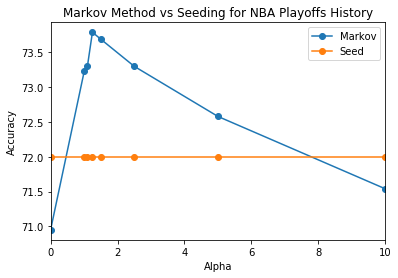

time: 243 ms


In [264]:
accuracy_plot = accuracy_results.iloc[0:8,:].plot.line('Alpha', ['Markov', 'Seed'], style='-o')
accuracy_plot.set_ylabel("Accuracy")
accuracy_plot.set_title("Markov Method vs Seeding for NBA Playoffs History")

In [ ]:
# Get and save all data

In [17]:
regular_season_data = get_regular_season_results(1977, 2018)

time: 9min 22s


In [107]:
playoff_data = get_playoff_results(1977, 2017)

time: 1min 17s


In [66]:
standings_data = get_standings(1977, 2017)

time: 2min 8s


In [119]:
for year,info in regular_season_data.items():
    info.to_csv('/Users/JasonKatz/Desktop/NBA_Data/Regular_Season/' + str(year) + '.csv')

time: 17.6 ms


In [108]:
for year,info in playoff_data.items():
    info.to_csv('/Users/JasonKatz/Desktop/NBA_Data/Playoffs/' + str(year) + '.csv')

time: 77.1 ms


In [67]:
with open('/Users/JasonKatz/Desktop/NBA_Data/standings.json', 'w') as file:
    json.dump(standings_data, file)

time: 10.5 ms


In [ ]:
# Scrap code to generate figures

In [26]:
alpha=0
teams = list(np.sort(list(set(regular_season_data['2017']['Home/Neutral']))))
voting_matrix = pd.DataFrame(0, columns=teams, index=teams)
for idx,row in regular_season_data['2017'].iterrows():
    winning_team, losing_team = game_result(row)
    if alpha == 0:
        voting_matrix.loc[winning_team, losing_team] += alpha
        voting_matrix.loc[losing_team, winning_team] += 1
    else:
        voting_matrix.loc[winning_team, losing_team] += 1
        voting_matrix.loc[losing_team, winning_team] += alpha
voting_matrix = voting_matrix.div(voting_matrix.sum(axis=1), axis=0)
voting_matrix = np.matrix(voting_matrix)
S, U = eig(voting_matrix.T)
stationary = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
stationary = stationary / np.sum(stationary)
ratings_order = np.argsort(stationary)
rankings = list(reversed([teams[rat] for rat in ratings_order]))

time: 1.48 s


In [69]:
ratings = [round(np.real(rat).item(),4) for rat in list(reversed(np.sort(stationary)))]

time: 2.3 ms


In [87]:
team_ratings = pd.DataFrame()
for idx,rating in enumerate(ratings):
    team_ratings[idx+1] = [rankings[idx], rating]
team_ratings.index = ['Team', 'Rating']

time: 25.7 ms


In [88]:
team_ratings

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Team,Golden State Warriors,San Antonio Spurs,Los Angeles Clippers,Houston Rockets,Memphis Grizzlies,Utah Jazz,Boston Celtics,Cleveland Cavaliers,Oklahoma City Thunder,Toronto Raptors,...,Dallas Mavericks,Sacramento Kings,New Orleans Pelicans,Charlotte Hornets,Los Angeles Lakers,Orlando Magic,New York Knicks,Philadelphia 76ers,Phoenix Suns,Brooklyn Nets
Rating,0.0555,0.0548,0.045,0.044,0.0429,0.0416,0.0405,0.0397,0.039,0.0385,...,0.027,0.0268,0.0259,0.0256,0.024,0.0228,0.0224,0.0196,0.0195,0.0131


time: 42 ms
